<a href="https://colab.research.google.com/github/ayuviscod/MachineLearningTasks/blob/main/Klasifikasi_Review_Samsung_Store_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install streamlit joblib scikit-learn pandas numpy
!pip -q install Sastrawi



In [ ]:
from google.colab import files;

uploaded = files.upload()

Saving Dataset Samsung Official Store.csv to Dataset Samsung Official Store (1).csv


In [ ]:
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import joblib



print("✅ Imports loaded.")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)


✅ Imports loaded.
pandas: 2.2.2
numpy: 2.0.2


In [ ]:
# =========================
# Config + cek dataset (output)
# =========================
DATA_PATH = Path("Dataset Samsung Official Store.csv")
OUT_DIR = Path("outputs_nb")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = OUT_DIR / "nb_tokopedia_posneg.joblib"
REPORT_PATH = OUT_DIR / "evaluation_report.json"
PRED_SAMPLE_PATH = OUT_DIR / "test_predictions_sample.csv"

VALID_LABELS = {"positif", "negatif"}
MIN_WORDS = 3
RANDOM_STATE = 42

print("✅ Config set.")
print("DATA_PATH:", DATA_PATH)
print("Dataset exists?:", DATA_PATH.exists())
print("OUT_DIR:", OUT_DIR.resolve())


✅ Config set.
DATA_PATH: Dataset Samsung Official Store.csv
Dataset exists?: True
OUT_DIR: /content/outputs_nb


In [ ]:
# =========================
# Stopwords & noise tokens (output)
# =========================
STOPWORDS_ID = {
    "dan", "yang", "di", "ke", "dari", "dengan", "untuk", "pada", "ini", "itu", "sih", "nih", "deh", "dong",
    "lah", "ya", "iya", "aja", "kok", "pun", "juga", "jadi", "karena", "atau", "tapi", "biar", "agar",
    "saya", "aku", "kamu", "dia", "kami", "kita", "mereka", "gue", "lu",
    "yg", "udah", "sudah", "baru", "lagi", "banget", "bgt", "aja",
    "dgn", "dlm", "td", "krn", "pd", "dr", "utk",
    "ada", "buat", "dapat", "bisa", "kalo", "kalau", "saat", "ketika", "seperti", "lebih", "pake", "pakai",
    "mau", "masih", "harus", "semoga", "terima", "kasih",
    "ok", "oke", "mantul",
    "nya",
}

# Pastikan negasi tetap ada (tidak dibuang)
for w in ["tidak", "nggak", "gak", "ga", "gk", "bukan", "belum"]:
    STOPWORDS_ID.discard(w)

NOISE_TOKENS = {"den", "semo", "san", "tgl", "po"}

print("✅ Stopwords ready.")
print("Stopwords count:", len(STOPWORDS_ID))
print("Negation kept?:", {w: (w in STOPWORDS_ID) for w in ["tidak","nggak","gak","ga","gk","bukan","belum"]})
print("Noise tokens:", NOISE_TOKENS)


✅ Stopwords ready.
Stopwords count: 72
Negation kept?: {'tidak': False, 'nggak': False, 'gak': False, 'ga': False, 'gk': False, 'bukan': False, 'belum': False}
Noise tokens: {'den', 'semo', 'tgl', 'po', 'san'}


In [ ]:
# =========================
# Stemming (Bahasa Indonesia) - Sastrawi
# =========================
_factory = StemmerFactory()
stemmer = _factory.create_stemmer()

# token yang jangan distem supaya tidak rusak
KEEP_TOKENS = {"customer_service", "whatsapp"}
NEGATION_TOKENS = {"tidak", "nggak", "gak", "ga", "gk", "bukan", "belum"}


In [ ]:
# Fungsi cleaning struktural
def clean_structural(df: pd.DataFrame) -> pd.DataFrame:
    required_cols = ["label", "review_text"]
    for c in required_cols:
        if c not in df.columns:
            raise ValueError(f"Kolom wajib '{c}' tidak ditemukan di dataset.")

    df = df.copy()
    df["label"] = df["label"].astype(str).str.strip().str.lower()
    df = df[df["label"].isin(VALID_LABELS)]

    df["review_text"] = df["review_text"].fillna("").astype(str)
    df["review_text"] = df["review_text"].str.replace(r"\s+", " ", regex=True).str.strip()
    df = df[df["review_text"].str.len() > 0]

    # dedup
    dedup_cols = [c for c in ["label", "review_text", "reviewer", "relative_time", "product_url"] if c in df.columns]
    if len(dedup_cols) >= 2:
        df = df.drop_duplicates(subset=dedup_cols)

    return df.reset_index(drop=True)



In [ ]:
def preprocess_text(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.lower()

    # buang URL
    s = re.sub(r"http\S+|www\.\S+", " ", s)

    # normalisasi negasi/slang
    s = re.sub(r"\b(gk|ga|gak|ngga)\b", " nggak ", s)
    s = re.sub(r"\btdk\b", " tidak ", s)

    # normalisasi campuran Indo/Inggris & slang marketplace
    s = re.sub(r"\bfast\b", " cepat ", s)
    s = re.sub(r"\bslow\b", " lambat ", s)
    s = re.sub(r"\brespon\b", " respons ", s)
    s = re.sub(r"\bresp\b", " respons ", s)

    s = re.sub(r"\brekomend(ed)?\b|\brecommend(ed)?\b", " rekomendasi ", s)
    s = re.sub(r"\bori\b", " original ", s)

    s = re.sub(r"\bcs\b", " customer_service ", s)
    s = re.sub(r"\bwa\b", " whatsapp ", s)

    # bersihkan karakter selain huruf/angka/spasi
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    tokens = s.split()
    tokens = [t for t in tokens if t not in NOISE_TOKENS and t != "nya"]

    # =========================
    # ✅ Stemming per token (Sastrawi)
    # - skip token khusus, token ber-underscore, token mengandung angka
    # - opsional: skip negasi agar makna tetap kuat
    # =========================
    stemmed_tokens = []
    for t in tokens:
        if (t in KEEP_TOKENS) or ("_" in t) or (any(ch.isdigit() for ch in t)):
            stemmed_tokens.append(t)
        elif t in NEGATION_TOKENS:
            stemmed_tokens.append(t)  # aman: tidak distem
        else:
            # stem hanya token alfabet (biar lebih bersih)
            if t.isalpha():
                stemmed_tokens.append(stemmer.stem(t))
            else:
                stemmed_tokens.append(t)

    return " ".join(stemmed_tokens)


In [ ]:
# Fungsi filter minimal kata

def filter_min_words(df: pd.DataFrame, text_col: str, min_words: int) -> pd.DataFrame:
    if min_words <= 0:
        return df
    wc = df[text_col].str.split().apply(len)
    return df[wc >= min_words].reset_index(drop=True)


In [ ]:
# Load data & cleaning

df = pd.read_csv(DATA_PATH)
df_clean = clean_structural(df)

df_clean["text_clean"] = df_clean["review_text"].map(preprocess_text)
df_clean = df_clean[df_clean["text_clean"].str.len() > 0].reset_index(drop=True)
df_clean = filter_min_words(df_clean, "text_clean", MIN_WORDS)



X = df_clean["text_clean"]
y = df_clean["label"]

print("Rows used:", len(df_clean))
print("Label distribution:\n", df_clean["label"].value_counts())
df_clean.head()




Rows used: 857
Label distribution:
 label
negatif    476
positif    381
Name: count, dtype: int64


,row_id,label,product_url,relative_time,reviewer,review_text,helpful_count,has_reply,product_image_url,reviewer_avatar_url,text_clean
0,1,positif,https://www.tokopedia.com/samsung-official-sto...,2 minggu lalu,N***o,Kejernihan lensa: Cakep Kualitas pengerjaan: S...,1,False,https://lf-web-assets.tokopedia-static.net/obj...,https://images.tokopedia.net/img/cache/100-squ...,jernih lensa cakep kualitas kerja satset sampe...
1,2,positif,https://www.tokopedia.com/samsung-official-sto...,2 minggu lalu,J***g,"Bagus sekali , realpict pengiriman aman",0,False,https://images.tokopedia.net/img/cache/200-squ...,https://images.tokopedia.net/img/cache/100-squ...,bagus sekali realpict kirim aman
2,5,positif,https://www.tokopedia.com/samsung-official-sto...,2 minggu lalu,F***a,Bagus amanah semoga awet ya hp nya. Pengiriman...,0,False,https://images.tokopedia.net/img/cache/200-squ...,https://images.tokopedia.net/img/cache/100-squ...,bagus amanah moga awet ya hp kirim 3hri ke bek...
3,6,positif,https://www.tokopedia.com/samsung-official-sto...,2 minggu lalu,O***g,"Ini pertama kali beli HP online lewat tiktok, ...",1,False,https://images.tokopedia.net/img/cache/200-squ...,https://images.tokopedia.net/img/cache/100-squ...,ini pertama kali beli hp online lewat tiktok n...
4,7,positif,https://www.tokopedia.com/samsung-official-sto...,6 hari lalu,B***n,"Barangnya sudah dicoba, berfungsi dengan baik,...",0,True,https://images.tokopedia.net/img/cache/200-squ...,https://images.tokopedia.net/img/cache/100-squ...,barang sudah coba fungsi dengan baik packingny...


In [ ]:
# Split train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("✅ Train-test split done.")
print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("\nTrain label dist (proporsi):\n", y_train.value_counts(normalize=True))
print("\nTest label dist (proporsi):\n", y_test.value_counts(normalize=True))

✅ Train-test split done.
Train size: 685
Test size: 172

Train label dist (proporsi):
 label
negatif    0.554745
positif    0.445255
Name: proportion, dtype: float64

Test label dist (proporsi):
 label
negatif    0.55814
positif    0.44186
Name: proportion, dtype: float64


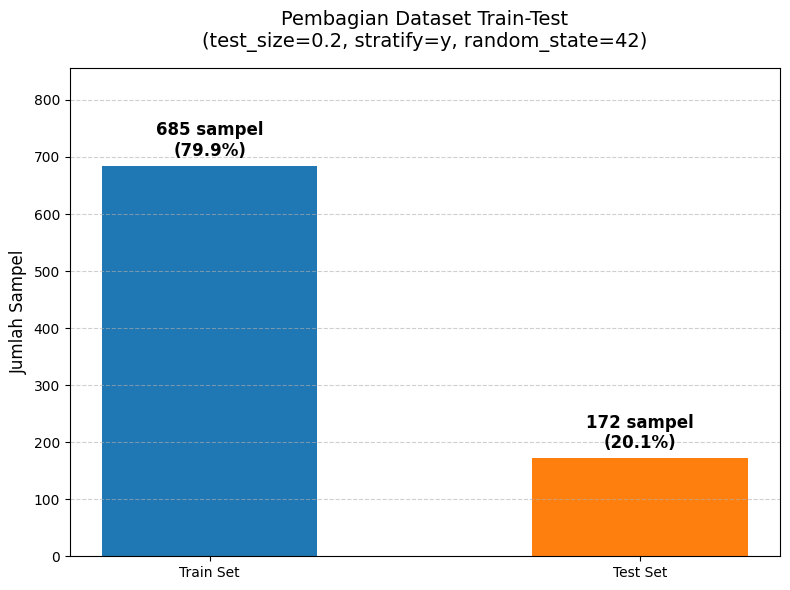

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data dari notebook kamu
train_size = 685
test_size = 172
total = train_size + test_size

labels = ['Train Set', 'Test Set']
sizes = [train_size, test_size]
percentages = [train_size/total * 100, test_size/total * 100]

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(labels, sizes, color=['#1f77b4', '#ff7f0e'], width=0.5)

# Tampilkan nilai jumlah + persentase di atas batang
for bar, size, pct in zip(bars, sizes, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 10,
            f'{size} sampel\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Jumlah Sampel', fontsize=12)
ax.set_title('Pembagian Dataset Train-Test\n(test_size=0.2, stratify=y, random_state=42)', fontsize=14, pad=15)
ax.set_ylim(0, max(sizes) * 1.25)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Opsional: simpan gambar untuk jurnal
# plt.savefig('pembagian_dataset_bar.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
# Build model & train

base_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words=list(STOPWORDS_ID),

        min_df=2,
        max_df=0.90,

        max_features=20000,

        sublinear_tf=True,
        norm="l2",

        token_pattern=r"(?u)\b[a-z0-9]{3,}\b",
        lowercase=False
    )),
    ("nb", MultinomialNB(alpha=1.0))
])

print("✅ Base pipeline created.")
print("TFIDF params (ringkas):")
print({
    "ngram_range": base_pipe.named_steps["tfidf"].ngram_range,
    "min_df": base_pipe.named_steps["tfidf"].min_df,
    "max_df": base_pipe.named_steps["tfidf"].max_df,
    "max_features": base_pipe.named_steps["tfidf"].max_features,
    "sublinear_tf": base_pipe.named_steps["tfidf"].sublinear_tf,
})
print("NB alpha:", base_pipe.named_steps["nb"].alpha)
print("Training done.")


✅ Base pipeline created.
TFIDF params (ringkas):
{'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.9, 'max_features': 20000, 'sublinear_tf': True}
NB alpha: 1.0
Training done.


In [ ]:
# =========================
# GridSearchCV
# =========================
from sklearn.model_selection import StratifiedKFold



param_grid = {
    "tfidf__min_df": [2, 3, 5],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_features": [10000, 20000, 30000],
    "nb__alpha": [1.0, 1.5, 2.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("✅ Param grid & CV ready.")
print("Total combinations:", len(param_grid["tfidf__min_df"]) * len(param_grid["tfidf__ngram_range"]) * len(param_grid["tfidf__max_features"]) * len(param_grid["nb__alpha"]))
print("CV splits:", cv.get_n_splits())


✅ Param grid & CV ready.
Total combinations: 54
CV splits: 5


In [ ]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(
    estimator=base_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

search.fit(X_train, y_train)

print("✅ GridSearch finished.")
print("Best CV score (f1_macro):", search.best_score_)
print("Best params:", search.best_params_)

model = search.best_estimator_
print("✅ Best estimator selected.")


✅ GridSearch finished.
Best CV score (f1_macro): 0.9346000835392674
Best params: {'nb__alpha': 1.0, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
✅ Best estimator selected.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# prediksi train & test
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

train_acc = float(accuracy_score(y_train, pred_train))
test_acc = float(accuracy_score(y_test, pred_test))

cm = confusion_matrix(y_test, pred_test, labels=["negatif", "positif"])
report = classification_report(y_test, pred_test, digits=4, output_dict=True)

print("✅ Evaluation done.")
print("Train accuracy:", train_acc)
print("Test  accuracy:", test_acc)
print("Confusion matrix (labels: negatif, positif):\n", cm)

print("\nClassification report:\n")
print(classification_report(y_test, pred_test, digits=4))




✅ Evaluation done.
Train accuracy: 0.9751824817518249
Test  accuracy: 0.9127906976744186
Confusion matrix (labels: negatif, positif):
 [[88  8]
 [ 7 69]]

Classification report:

              precision    recall  f1-score   support

     negatif     0.9263    0.9167    0.9215        96
     positif     0.8961    0.9079    0.9020        76

    accuracy                         0.9128       172
   macro avg     0.9112    0.9123    0.9117       172
weighted avg     0.9130    0.9128    0.9128       172



In [ ]:
# Save sample predictions, model, report

pd.DataFrame({
    "text_clean": X_test.values,
    "label_true": y_test.values,
    "label_pred": pred_test
}).to_csv(PRED_SAMPLE_PATH, index=False, encoding="utf-8-sig")

# simpan model terbaik
joblib.dump(model, MODEL_PATH)

# simpan report hasil training
result = {
    "n_rows_after_cleaning": int(len(df_clean)),
    "label_distribution": df_clean["label"].value_counts().to_dict(),

    # simpan train vs test (biar kelihatan overfit atau tidak)
    "train_accuracy": train_acc,
    "accuracy": test_acc,  # test accuracy

    "confusion_matrix_labels": ["negatif", "positif"],
    "confusion_matrix": cm.tolist(),
    "classification_report": report,

    # simpan parameter terbaik dari GridSearchCV
    "best_params": search.best_params_,

    "saved_model_path": str(MODEL_PATH),
    "saved_test_sample_path": str(PRED_SAMPLE_PATH),

    "min_words": MIN_WORDS,
    "token_pattern": r"(?u)\b[a-z0-9]{3,}\b"
}

REPORT_PATH.write_text(json.dumps(result, ensure_ascii=False, indent=2), encoding="utf-8")

print("=== TRAIN DONE ===")
print("Rows used:", result["n_rows_after_cleaning"])
print("Label distribution:", result["label_distribution"])
print("Train accuracy:", result["train_accuracy"])
print("Test  accuracy:", result["accuracy"])
print("Best params:", result["best_params"])
print("Model saved:", result["saved_model_path"])
print("Report saved:", str(REPORT_PATH))
print("Test sample saved:", result["saved_test_sample_path"])

=== TRAIN DONE ===
Rows used: 857
Label distribution: {'negatif': 476, 'positif': 381}
Train accuracy: 0.9751824817518249
Test  accuracy: 0.9127906976744186
Best params: {'nb__alpha': 1.0, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Model saved: outputs_nb/nb_tokopedia_posneg.joblib
Report saved: outputs_nb/evaluation_report.json
Test sample saved: outputs_nb/test_predictions_sample.csv


In [ ]:
%%writefile app.py
import re
import json
from pathlib import Path

import joblib
import streamlit as st
import matplotlib.pyplot as plt

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

OUT_DIR = Path("outputs_nb")
MODEL_PATH = OUT_DIR / "nb_tokopedia_posneg.joblib"
REPORT_PATH = OUT_DIR / "evaluation_report.json"

# Keterangan sumber data
DATA_SOURCE_TEXT = (
    "Dataset diambil dari ulasan (review) Tokopedia pada **Samsung Official Store**. "
    "Model ini melakukan klasifikasi sentimen **positif**."
)

NOISE_TOKENS = {"den", "semo", "san", "tgl", "po"}

# =========================
# Stemming (Bahasa Indonesia) - Sastrawi
# =========================
_factory = StemmerFactory()
stemmer = _factory.create_stemmer()

# token yang jangan distem supaya tidak rusak
KEEP_TOKENS = {"customer_service", "whatsapp"}
NEGATION_TOKENS = {"tidak", "nggak", "gak", "ga", "gk", "bukan", "belum"}


def preprocess_text(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.lower()

    # buang URL
    s = re.sub(r"http\S+|www\.\S+", " ", s)

    # normalisasi negasi/slang
    s = re.sub(r"\b(gk|ga|gak|ngga)\b", " nggak ", s)
    s = re.sub(r"\btdk\b", " tidak ", s)

    # normalisasi campuran Indo/Inggris & slang marketplace
    s = re.sub(r"\bfast\b", " cepat ", s)
    s = re.sub(r"\bslow\b", " lambat ", s)
    s = re.sub(r"\brespon\b", " respons ", s)
    s = re.sub(r"\bresp\b", " respons ", s)
    s = re.sub(r"\brekomend(ed)?\b|\brecommend(ed)?\b", " rekomendasi ", s)
    s = re.sub(r"\bori\b", " original ", s)

    s = re.sub(r"\bcs\b", " customer_service ", s)
    s = re.sub(r"\bwa\b", " whatsapp ", s)

    # bersihkan karakter selain huruf/angka/spasi
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()

    tokens = s.split()
    tokens = [t for t in tokens if t not in NOISE_TOKENS and t != "nya"]

    # =========================
    # ✅ Stemming per token (Sastrawi)
    # - skip token khusus, token ber-underscore, token mengandung angka
    # - skip negasi agar makna tetap kuat
    # =========================
    stemmed_tokens = []
    for t in tokens:
        if (t in KEEP_TOKENS) or ("_" in t) or any(ch.isdigit() for ch in t):
            stemmed_tokens.append(t)
        elif t in NEGATION_TOKENS:
            stemmed_tokens.append(t)
        else:
            if t.isalpha():
                stemmed_tokens.append(stemmer.stem(t))
            else:
                stemmed_tokens.append(t)

    return " ".join(stemmed_tokens)


@st.cache_resource
def load_model():
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model tidak ditemukan: {MODEL_PATH.resolve()}")
    return joblib.load(MODEL_PATH)


def load_report():
    """Load metrik evaluasi (accuracy, dll) dari file hasil training."""
    if not REPORT_PATH.exists():
        return None
    try:
        return json.loads(REPORT_PATH.read_text(encoding="utf-8"))
    except Exception:
        return None


def predict_single(model, text: str):
    tclean = preprocess_text(text)
    if not tclean:
        return None

    label = model.predict([tclean])[0]

    proba = None
    classes = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba([tclean])[0]
        try:
            classes = list(model.named_steps["nb"].classes_)
        except Exception:
            classes = None

    return tclean, label, classes, proba


st.set_page_config(page_title="Sentimen Tokopedia (Naive Bayes)", layout="wide")
st.title("Klasifikasi Sentimen Ulasan Tokopedia (Naive Bayes)")

# keterangan sumber data
st.markdown(DATA_SOURCE_TEXT)

# akurasi dari report
report = load_report()
acc = report.get("accuracy") if isinstance(report, dict) else None
if acc is not None:
    st.info(f"**Akurasi model (test split): {acc:.2%}**")
else:
    st.warning("Akurasi model belum ditemukan. Pastikan file outputs_nb/evaluation_report.json tersedia.")

# pie chart distribusi label (jika report ada)
if isinstance(report, dict):
    label_dist = report.get("label_distribution", None)
    n_rows = report.get("n_rows_after_cleaning", None)

    if isinstance(label_dist, dict) and len(label_dist) > 0:
        st.subheader("Distribusi Label Dataset Training")

        if n_rows is not None:
            st.caption(f"Total data setelah cleaning (dipakai training): {n_rows}")

        labels_order = ["positif", "negatif"]
        values = [int(label_dist.get(k, 0)) for k in labels_order]
        labels = [f"{k} ({v})" for k, v in zip(labels_order, values)]

        fig, ax = plt.subplots(figsize=(4.2, 3.0), dpi=140)
        fig.patch.set_alpha(0)
        ax.set_facecolor("none")

        wedges, texts, autotexts = ax.pie(
            values,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            textprops={"fontsize": 8, "color": "white"},
        )

        for t in autotexts:
            t.set_color("white")
            t.set_fontsize(8)

        ax.axis("equal")
        st.pyplot(fig, transparent=True, use_container_width=False)
    else:
        st.warning("label_distribution tidak ditemukan di evaluation_report.json. Jalankan training ulang agar file report terisi.")

st.caption("Input 1 kalimat untuk prediksi sentimen.")

model = load_model()

st.subheader("Prediksi 1 kalimat")
text = st.text_area("Masukkan komentar:", height=120)

if st.button("Prediksi", type="primary"):
    if not text.strip():
        st.warning("Teks masih kosong.")
    else:
        out = predict_single(model, text)
        if out is None:
            st.warning("Teks tidak valid setelah preprocessing.")
        else:
            tclean, label, classes, proba = out
            if label == "positif":
                st.success(f"Hasil: **{label.upper()}** ✅")
            else:
                st.error(f"Hasil: **{label.upper()}** ❌")

            st.write("Teks setelah preprocessing (dengan stemming):")
            st.code(tclean)

            if proba is not None and classes is not None:
                st.write("Probabilitas:")
                st.json({classes[i]: float(proba[i]) for i in range(len(classes))})


Overwriting app.py


In [ ]:
# Tampilkan contoh before-after preprocessing (untuk jurnal/paper)
import pandas as pd
import random

# Ambil 8 sampel acak (atau pilih manual yang representatif)
sample_idx = random.sample(df.index.tolist(), 8)
samples = df.loc[sample_idx, ['review_text']].copy()
samples['review_text'] = samples['review_text'].str.strip()

# Terapkan preprocessing
samples['text_clean'] = samples['review_text'].apply(preprocess_text)

# Buat tampilan tabel yang bagus
display_samples = samples.rename(columns={
    'review_text': 'Teks Asli (Original)',
    'text_clean': 'Teks Setelah Preprocessing'
})

# Tampilkan dengan style (untuk notebook)
display_samples_styled = display_samples.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_caption("Contoh Hasil Preprocessing Teks Ulasan")

display_samples_styled

,Teks Asli (Original),Teks Setelah Preprocessing
290,"packing aman , barang Ori , tested Ok , everything is working fine , recommended seller and item",packing aman barang original tested ok everything is working fine rekomendasi seller and item
837,Pembatalan ditolak padahal blum dkirim. Masih lama jg,batal tolak padahal blum dkirim masih lama jg
249,"Trimakasih toko nya amanah Kurir nya juga ramah, pengiriman cepat",trimakasih toko amanah kurir juga ramah kirim cepat
537,Masih 3 hari dah ijo gini buat video jadi harus ke servis center segera 😔,masih 3 hari dah ijo gin buat video jadi harus ke servis center segera
463,C gtu jg fftggyygyyyyyyyyyuuuuikj,c gtu jg fftggyygyyyyyyyyyuuuuikj
797,Sudah melakukan pre registrasi untuk mendapat SC+ 2 Tahun. Tapi sampai hari ini 28 Maret belum bisa diklaim. Ulasan akan saya perbarui bila sudah mendapat SC+ 2 Tahunnya.,sudah laku pre registrasi untuk dapat sc 2 tahun tapi sampai hari ini 28 maret belum bisa klaim ulas akan saya baru bila sudah dapat sc 2 tahun
903,"Sekelas official store samsung, masa pengiriman tidak pakai kardus, cuma bubble wrap aja, itu rawan dus penyok2. Kalah deh sama penjual biasa yang non official store, leb...",kelas official store samsung masa kirim tidak pakai kardus cuma bubble wrap aja itu rawan dus penyok2 kalah deh sama jual biasa yang non official store leb
390,Bgussss bnget,bgussss bnget


In [ ]:
!pip install wordcloud

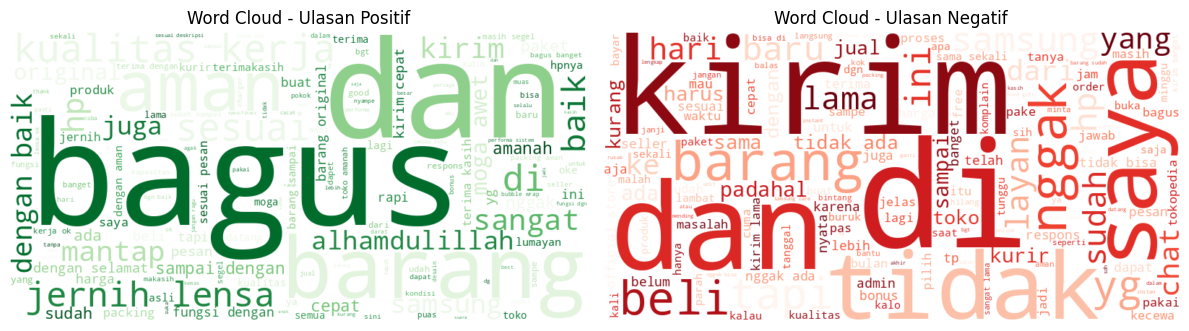

In [ ]:
from wordcloud import WordCloud

# Pisah teks positif & negatif
text_pos = ' '.join(df_clean[df_clean['label']=='positif']['text_clean'])
text_neg = ' '.join(df_clean[df_clean['label']=='negatif']['text_clean'])

# Word Cloud Positif
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wc_pos = WordCloud(width=800, height=400, background_color='white',
                   colormap='Greens', max_words=150).generate(text_pos)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Positif')

# Word Cloud Negatif
plt.subplot(1, 2, 2)
wc_neg = WordCloud(width=800, height=400, background_color='white',
                   colormap='Reds', max_words=150).generate(text_neg)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Negatif')

plt.tight_layout()
plt.show()

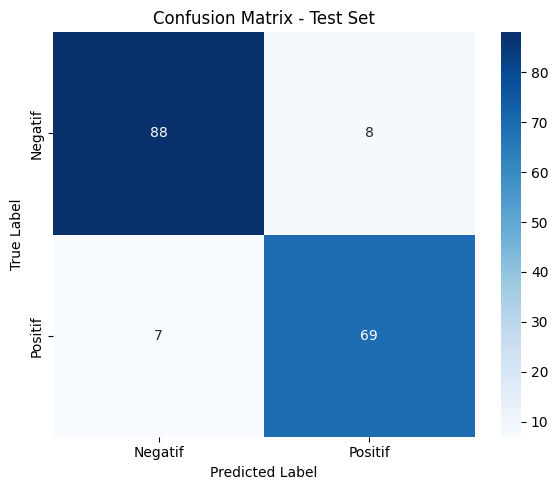

In [ ]:
# Cell baru setelah evaluasi
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negatif', 'Positif'],
            yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

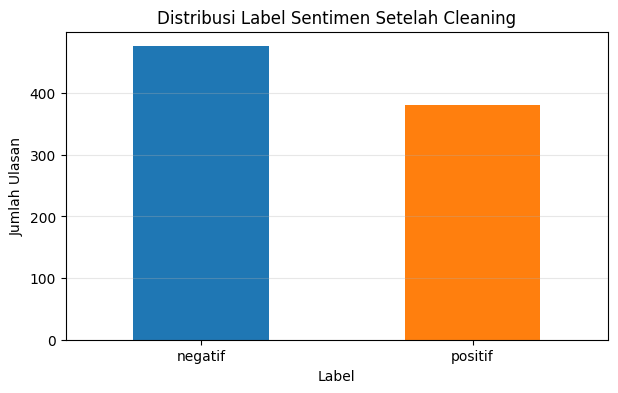

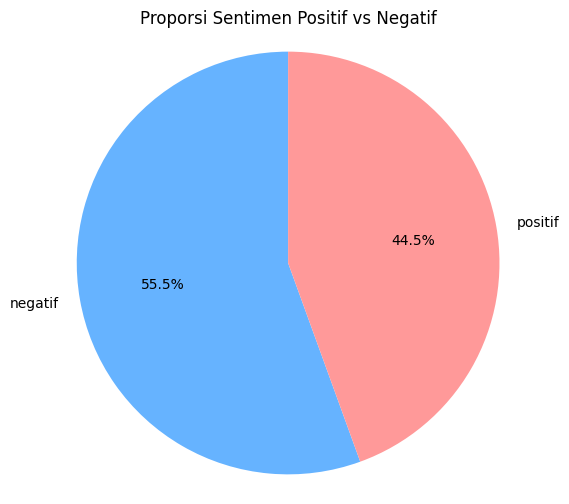

In [ ]:
# Distribusi Label - Bar Plot
plt.figure(figsize=(7, 4))
df_clean['label'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Distribusi Label Sentimen Setelah Cleaning')
plt.xlabel('Label')
plt.ylabel('Jumlah Ulasan')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Pie Chart (alternatif)
plt.figure(figsize=(6, 6))
plt.pie(df_clean['label'].value_counts(),
        labels=df_clean['label'].value_counts().index,
        autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999'],
        startangle=90)
plt.title('Proporsi Sentimen Positif vs Negatif')
plt.axis('equal')
plt.show()

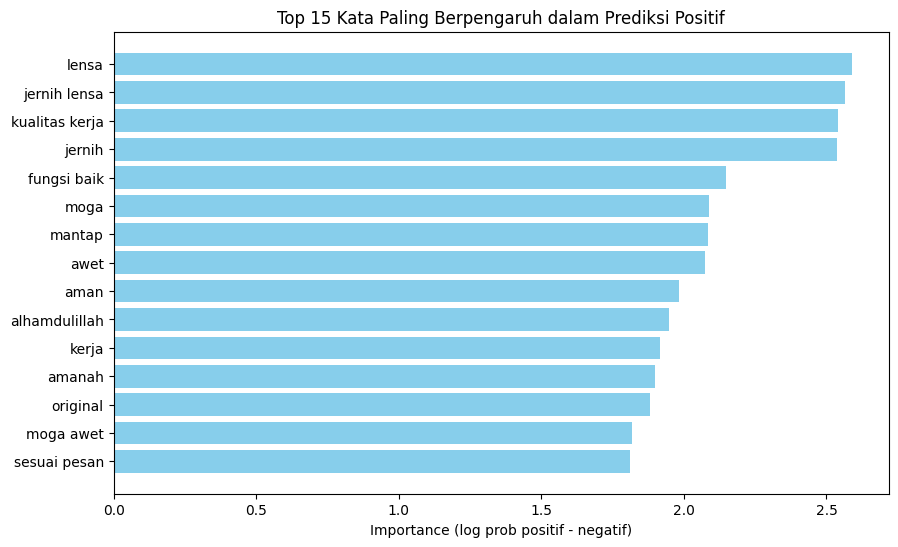

In [ ]:
# Ambil TF-IDF dari pipeline
tfidf = model.named_steps['tfidf']
feature_names = tfidf.get_feature_names_out()

# Ambil koefisien Naive Bayes (log probabilities)
log_prob = model.named_steps['nb'].feature_log_prob_

# Hitung importance (selisih log prob kelas positif - negatif)
importance = log_prob[1] - log_prob[0]  # asumsi index 1 = positif

# Urutkan & ambil top 15
top_n = 15
top_idx = importance.argsort()[-top_n:][::-1]
top_words = [feature_names[i] for i in top_idx]
top_scores = importance[top_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores, color='skyblue')
plt.xlabel('Importance (log prob positif - negatif)')
plt.title('Top 15 Kata Paling Berpengaruh dalam Prediksi Positif')
plt.gca().invert_yaxis()
plt.show()

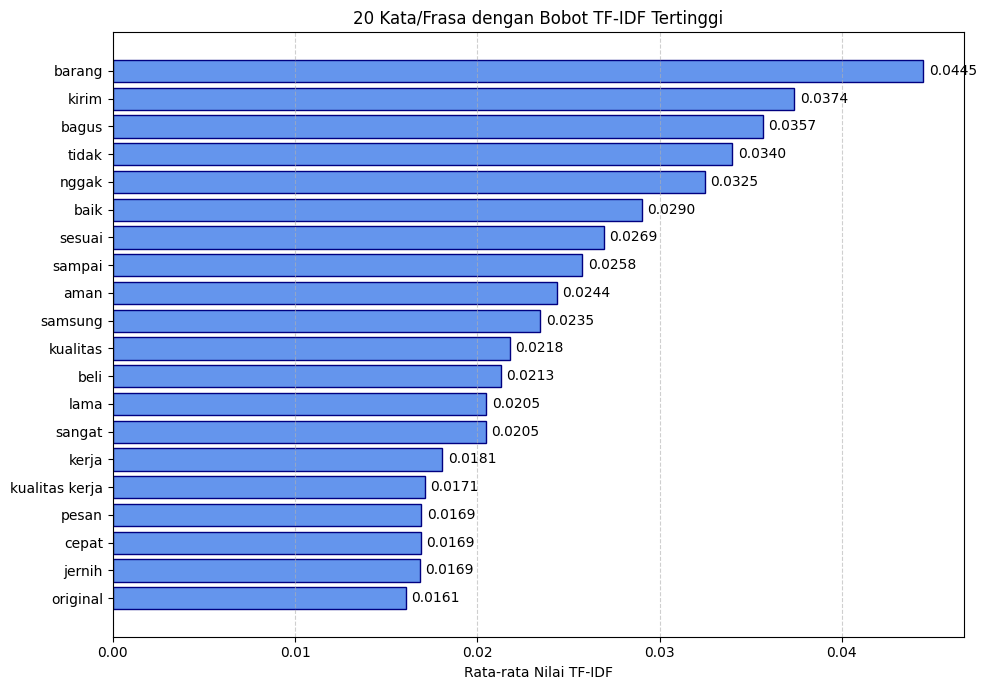

In [ ]:
# Kode untuk menghasilkan gambar Top 20 TF-IDF (paste di cell notebook)
import matplotlib.pyplot as plt
import numpy as np

tfidf = model.named_steps['tfidf']
X_tfidf = tfidf.transform(df_clean['text_clean'])
mean_tfidf = np.mean(X_tfidf.toarray(), axis=0)
feature_names = tfidf.get_feature_names_out()

top_n = 20
top_idx = mean_tfidf.argsort()[-top_n:][::-1]
top_words = [feature_names[i] for i in top_idx]
top_scores = mean_tfidf[top_idx]

plt.figure(figsize=(10, 7))
plt.barh(top_words, top_scores, color='cornflowerblue', edgecolor='navy')
plt.xlabel('Rata-rata Nilai TF-IDF')
plt.title('20 Kata/Frasa dengan Bobot TF-IDF Tertinggi')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

for i, v in enumerate(top_scores):
    plt.text(v + 0.0003, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('top_tfidf_words.png', dpi=300, bbox_inches='tight')
plt.show()

Top 20 per kelas:

POSITIF:
cepat                0.15540
aman                 0.13844
puas                 0.13306
original             0.12966
rekomendasi          0.11803
realpict             0.11393
puas banget          0.11295
banget               0.11295
mantap               0.10960
barang               0.10312
bagus                0.09902
aman realpict        0.07716
cepat aman           0.07716
mantap rekomendasi   0.07716
realpict mantap      0.07716
samsung              0.07087
samsung original     0.07087
cepat puas           0.07087
original aman        0.07087
aman cepat           0.07087

NEGATIF:
lambat               0.13340
kecewa               0.13253
tidak                0.13133
barang               0.10848
lambat barang        0.10848
rusak                0.10744
buruk                0.10646
lama                 0.10398
rusak kecewa         0.06723
pengiriman           0.06723
sekali               0.06723
tidak puas           0.06723
cacat                0.06723
cacat

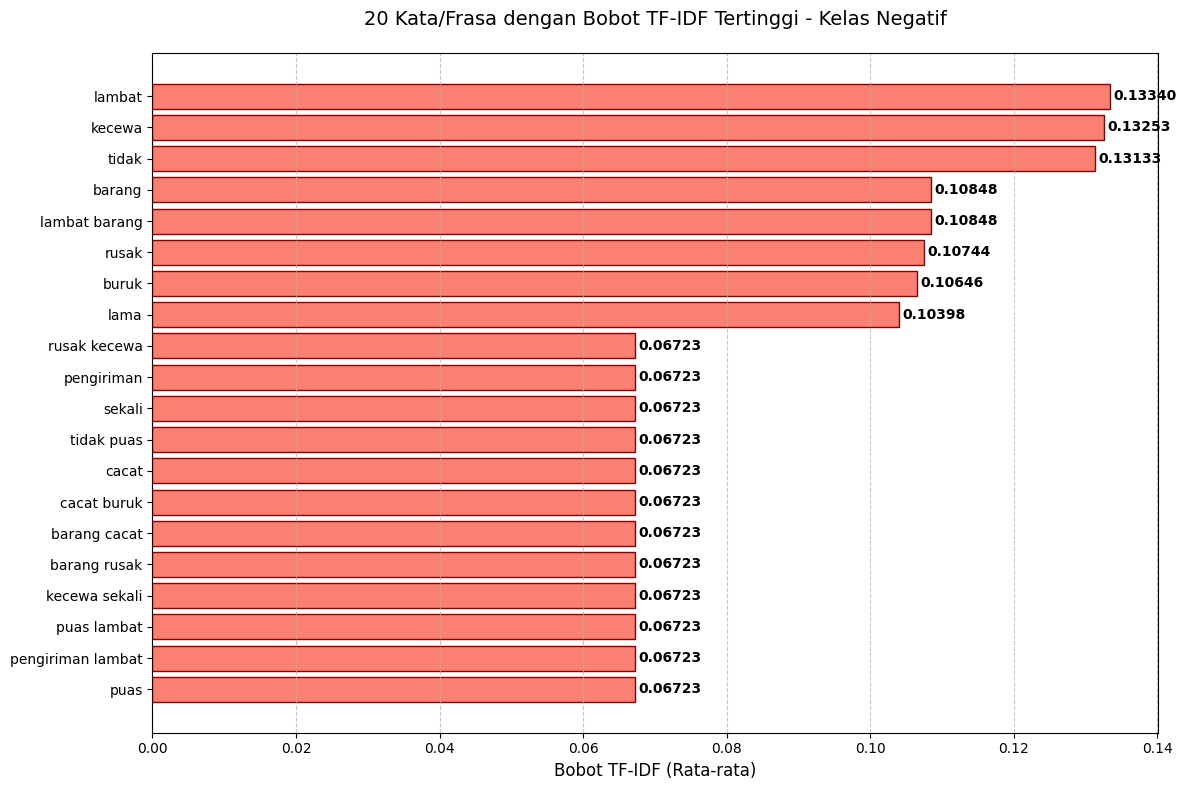

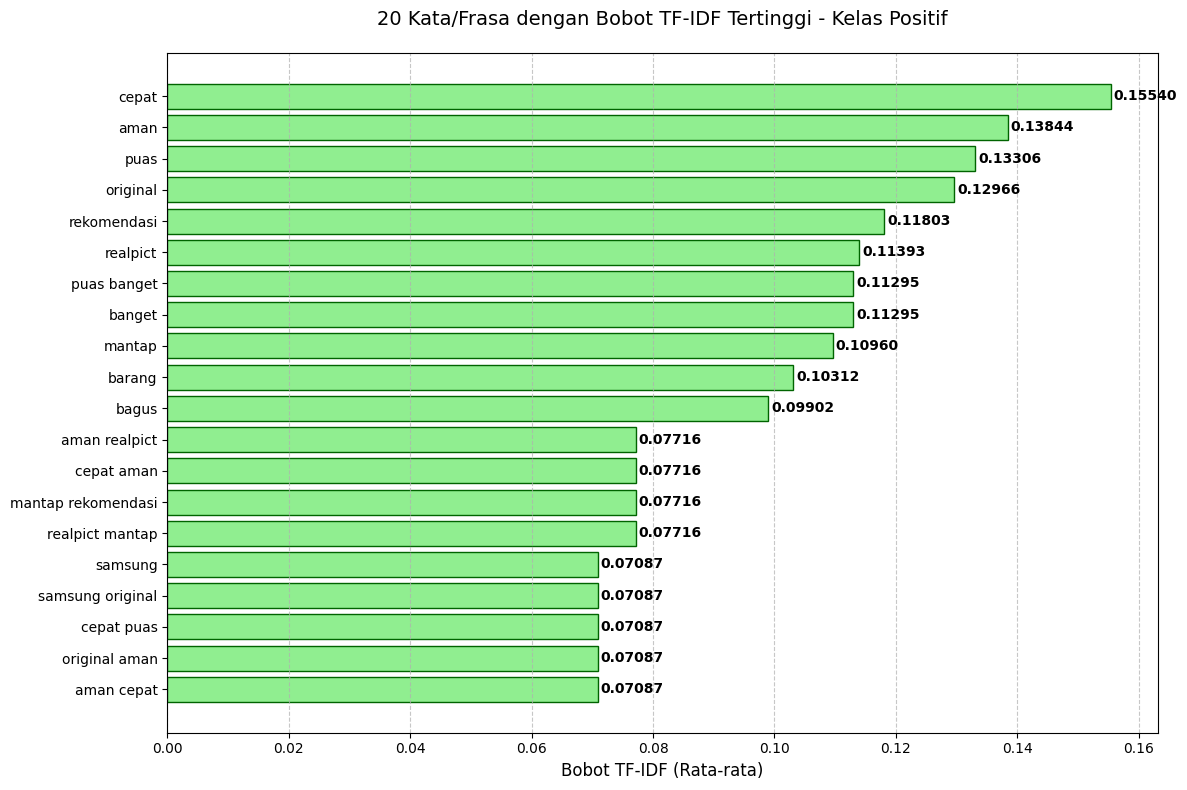

In [ ]:
# 1. Instal library yang diperlukan (jalankan sekali)
!pip install -q wordcloud matplotlib seaborn pandas numpy scikit-learn

# 2. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# 3. Asumsikan df_clean sudah ada (dari notebook utama Anda)
# Jika belum ada, uncomment dan sesuaikan path dataset Anda
# df = pd.read_csv('Dataset Samsung Official Store.csv')
# df_clean = ... (proses preprocessing Anda di sini)

# Untuk demo/test cepat, gunakan data dummy (ganti dengan df_clean asli Anda)
data_dummy = {
    'text_clean': [
        'barang bagus cepat kirim original mantap aman puas',
        'pengiriman lambat barang rusak kecewa sekali',
        'tidak sesuai lama banget nggak bagus',
        'samsung original aman cepat puas banget',
        'kirim lama rusak tidak recommended kecewa',
        'bagus sekali kualitas baik original realpict',
        'tidak puas lambat barang cacat buruk',
        'cepat aman realpict mantap rekomendasi',
        'kecewa buruk packing jelek respon lambat',
        'puas banget rekomendasi barang ori cepat'
    ],
    'label': ['positif', 'negatif', 'negatif', 'positif', 'negatif', 'positif', 'negatif', 'positif', 'negatif', 'positif']
}
df_clean = pd.DataFrame(data_dummy)

# =============================================
# Fungsi untuk mendapatkan top N kata/frasa TF-IDF per kelas
# =============================================
def get_top_tfidf_per_class(df, label_col='label', text_col='text_clean', n=20):
    results = {}
    for lbl in df[label_col].unique():
        df_class = df[df[label_col] == lbl]
        if df_class.empty:
            continue
        tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=1)
        X = tfidf.fit_transform(df_class[text_col])
        mean_tfidf = np.mean(X.toarray(), axis=0)
        feature_names = tfidf.get_feature_names_out()
        top_indices = mean_tfidf.argsort()[-n:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        top_scores = mean_tfidf[top_indices]
        results[lbl] = list(zip(top_words, top_scores))
    return results

# Jalankan fungsi
top_per_class = get_top_tfidf_per_class(df_clean, n=20)

# Tampilkan hasil
print("Top 20 per kelas:")
for label, items in top_per_class.items():
    print(f"\n{label.upper()}:")
    for word, score in items:
        print(f"{word:20} {score:.5f}")

# =============================================
# Plot Bar Chart Horizontal untuk Negatif
# =============================================
if 'negatif' in top_per_class:
    words_neg, scores_neg = zip(*top_per_class['negatif'])
    plt.figure(figsize=(12, 8))
    bars_neg = plt.barh(words_neg, scores_neg, color='salmon', edgecolor='darkred')
    for bar in bars_neg:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f'{width:.5f}', va='center', fontsize=10, fontweight='bold')
    plt.xlabel('Bobot TF-IDF (Rata-rata)', fontsize=12)
    plt.title('20 Kata/Frasa dengan Bobot TF-IDF Tertinggi - Kelas Negatif', fontsize=14, pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('top_tfidf_negatif.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================
# Plot Bar Chart Horizontal untuk Positif
# =============================================
if 'positif' in top_per_class:
    words_pos, scores_pos = zip(*top_per_class['positif'])
    plt.figure(figsize=(12, 8))
    bars_pos = plt.barh(words_pos, scores_pos, color='lightgreen', edgecolor='darkgreen')
    for bar in bars_pos:
        width = bar.get_width()
        plt.text(width + 0.0005, bar.get_y() + bar.get_height()/2,
                 f'{width:.5f}', va='center', fontsize=10, fontweight='bold')
    plt.xlabel('Bobot TF-IDF (Rata-rata)', fontsize=12)
    plt.title('20 Kata/Frasa dengan Bobot TF-IDF Tertinggi - Kelas Positif', fontsize=14, pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('top_tfidf_positif.png', dpi=300, bbox_inches='tight')
    plt.show()

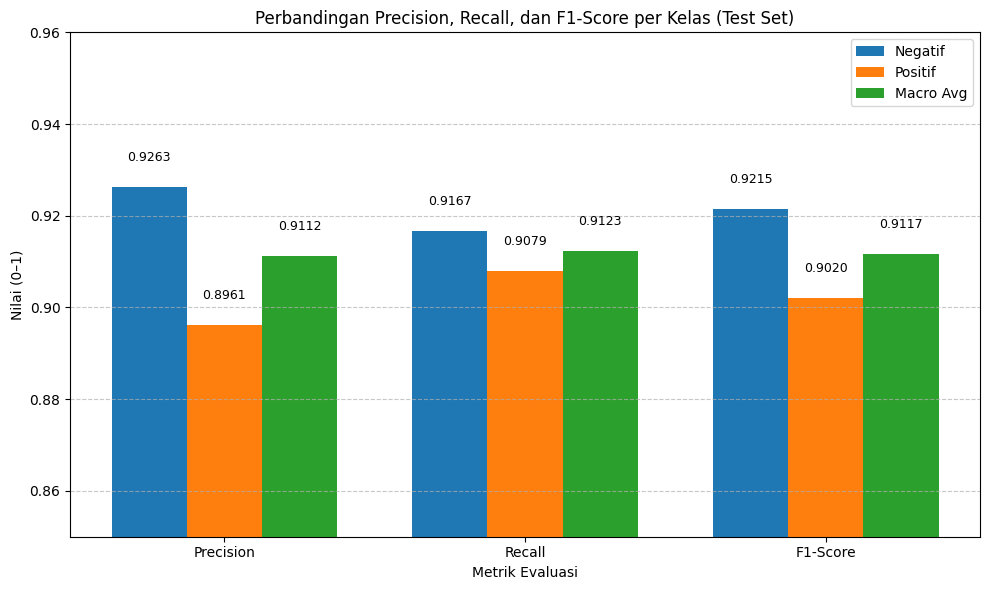

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data dari classification report kamu
metrics = ['Precision', 'Recall', 'F1-Score']
negatif  = [0.9263, 0.9167, 0.9215]
positif  = [0.8961, 0.9079, 0.9020]
macro    = [0.9112, 0.9123, 0.9117]

x = np.arange(len(metrics))  # posisi grup
width = 0.25                 # lebar tiap batang

fig, ax = plt.subplots(figsize=(10, 6))

# Buat 3 kelompok batang
ax.bar(x - width, negatif, width, label='Negatif', color='#1f77b4')
ax.bar(x,         positif, width, label='Positif', color='#ff7f0e')
ax.bar(x + width, macro,   width, label='Macro Avg', color='#2ca02c')

# Tambah nilai di atas batang
for i, v in enumerate(negatif):
    ax.text(i - width, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(positif):
    ax.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(macro):
    ax.text(i + width, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Label dan tampilan
ax.set_xlabel('Metrik Evaluasi')
ax.set_ylabel('Nilai (0–1)')
ax.set_title('Perbandingan Precision, Recall, dan F1-Score per Kelas (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0.85, 0.96)  # zoom agar lebih jelas (sesuaikan jika perlu)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Opsional: simpan untuk paper/jurnal
# plt.savefig('evaluation_metrics_bar.png', dpi=300, bbox_inches='tight')

In [ ]:
!pkill -f streamlit || true
!nohup streamlit run app.py --server.port 8501 --server.headless true --server.enableCORS false --server.enableXsrfProtection false > streamlit.log 2>&1 &
!sleep 2
!tail -n 50 streamlit.log


^C




In [ ]:
!curl -I http://localhost:8501

HTTP/1.1 200 OK
Server: TornadoServer/6.5.1
Content-Type: text/html
Date: Tue, 20 Jan 2026 07:42:38 GMT
Accept-Ranges: bytes
Etag: "0df883461e946938fb54d0f0c6477c716e7e6110de4f236b0d55468d7aa862c115cd9e1d75f21209c88d9392370b9c2d5afb440ea38e827c474b2b873eb001a8"
Last-Modified: Tue, 20 Jan 2026 07:13:14 GMT
Cache-Control: no-cache
Content-Length: 1522
Vary: Accept-Encoding



In [ ]:
!pip -q install pyngrok


In [ ]:
from pyngrok import ngrok

NGROK_AUTH_TOKEN = "38UEWkHh4Xfk16Dy7o7k890MJwT_7RwZk3BPwb9gKNeSYaQKj"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

print("✅ ngrok auth token set.")


✅ ngrok auth token set.


In [ ]:
import os
from pyngrok import ngrok

# (opsional) matikan proses streamlit lama kalau ada
!pkill -f streamlit || true

# jalankan streamlit di background
!streamlit run app.py --server.port 8501 --server.address 0.0.0.0 > streamlit.log 2>&1 &

# buka tunnel
public_url = ngrok.connect(8501, "http")
print("✅ Streamlit is running!")
print("🌐 Public URL:", public_url)
print("📄 Log file: streamlit.log (cek kalau ada error)")


^C
✅ Streamlit is running!
🌐 Public URL: NgrokTunnel: "https://beastlier-major-remiform.ngrok-free.dev" -> "http://localhost:8501"
📄 Log file: streamlit.log (cek kalau ada error)


In [ ]:
from pyngrok import ngrok

# tutup semua tunnel yang dibuat pyngrok di runtime ini
ngrok.kill()

print("✅ Semua tunnel ngrok di runtime ini sudah dimatikan.")


✅ Semua tunnel ngrok di runtime ini sudah dimatikan.


In [ ]:
from pyngrok import ngrok
import os

# matikan semua tunnel yg tercatat di runtime ini
try:
    for t in ngrok.get_tunnels():
        ngrok.disconnect(t.public_url)
except Exception as e:
    print("info (disconnect):", e)

try:
    ngrok.kill()
except Exception as e:
    print("info (kill):", e)

# kill proses OS-level (kalau ada yang nyangkut)
!pkill -f ngrok || true
!pkill -f streamlit || true

print("✅ ngrok & streamlit sudah di-reset.")


^C
^C
✅ ngrok & streamlit sudah di-reset.
